In [30]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import time
import winsound

In [2]:
mat = scipy.io.loadmat('mnist-original.mat') # lecture du fichier

In [3]:
data = np.transpose(mat['data'])
label = np.transpose(mat['label'])

In [4]:
X = [] # on créé une nouvelle liste qui va contenir nos matrices 28x28
for i in range(len(data)):
    X.append(data[i].reshape(784,1))

In [5]:
def index_chiffre(n, y):  # elle nous renvoie un tableau contenant les indices représentants le chiffre n
    index = []           # j'ai rajouté le y dans les arguments car je me servirai de cette fonction dans la suite
    for i in range(len(y)):
        if y[i]==n:
            index.append(i)
    return index

In [6]:
X_train, X_test, y_train, y_test = [], [], [], [] # comme la base de donnée est ordonnée, pour pouvoir diviser en train et test
for i in range(10): # on doit diviser en train test chaque set de chiffre, pour 0 pour 1 etc et on met tout dans nos matrices défeinies juste avant
    temp_x = [] # variable temporaire qui va contenir les matrices représentants le chiffre i
    temp_y = [] # variable temporaire qui va contenir les indexes représentants le chiffre i
    for j in (index_chiffre(i,label)):
        temp_x.append(X[j])
        temp_y.append(label[j])
    x_train, x_test, Y_train, Y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=42) # on divise en train test pour chaque jeu de matrice représentant le chiffre i
    X_train += x_train # à chaque itération on les mets dans nos matrices précédemment définies
    X_test += x_test
    y_train += Y_train
    y_test += Y_test

In [7]:
def concat(X, y, n): # la fonction qui va concaténer toutes les matrices représentants le chiffre n en une grosse matrice
    temp = np.zeros((784, len(index_chiffre(n, y))))
    for i,j in zip(index_chiffre(n, y), range(len(index_chiffre(n, y)))):
        temp[:,j]=X[i][:,0]
    return temp

In [8]:
start = time.time()
# on va créé une liste qui va contenir les 10 matrices concaténées
cwd = os.getcwd() # pour récupérer le dossier dans lequel on est
file = Path(cwd+str('\mat_chiffre.npy')) # le chemin de notre fichier

if file.is_file(): # on check si le fichier existe déjà, pour des problèmes de tailles quand je l'ai enregistré j'ai pris chaque matrice comme étant un vecteur colonne
    temp = np.load('mat_chiffre.npy', allow_pickle=True)
    mat_chiffre = []
    for i in range(10): # ici je récupère chacun de ces vecteurs colonnes que je retransforme en matrice
        mat_chiffre.append(temp[i].reshape(784,int(temp[i].shape[0]/784)))
else:
    mat_chiffre = []
    for i in range(10):
        mat_chiffre.append(concat(X_train, y_train, i).reshape(784*(concat(X_train, y_train, i).shape[1]),1))
    np.save('mat_chiffre.npy', mat_chiffre, allow_pickle=True)
    for i in range(10):
        mat_chiffre[i] = mat_chiffre[i].reshape(784,int(mat_chiffre[i].shape[0]/784))

print(time.time()-start)

0.2164013385772705


In [9]:
start = time.time()
# maintenant que la matrice contenant les matrices concaténées a été créée et sauvegardée on va s'en servir pour faire notre décomposition SVD qu'on va également sauvegarder
new_file = Path(cwd+str('\mat_svd.npy'))

if new_file.is_file(): # de même on check si le fichier existe déjà
    temp = np.load('mat_svd.npy', allow_pickle=True)
    mat_svd = []
    for i in range(3):
        mat_svd.append(temp[i]) # on a extrait les matrices U, S, V
    # maintenant on va les remettre dans la bonne taille
    U, S, V = [], [], []
    for i in range(10):
        U.append(mat_svd[0][i].reshape(784,784))
        S.append(mat_svd[1][i].reshape(784,))
        V.append(mat_svd[2][i].reshape(784, (mat_chiffre[i].shape[1])))
    U = np.array(U, dtype='float')
    S = np.array(S, dtype='float')
    #V = np.array(V, dtype='object') # je ne comprends pas pourquoi V ne veut pas être converti en liste numpy
    
else:
    U, S, V = [], [], []
    for i in range(10):                                                       # ici U sera toujours de taille 784*784 car le min entre le nombre de lignes et de colonnes de toutes les matrices de mat_chiffre est 784
        U.append(np.linalg.svd(mat_chiffre[i], full_matrices=False)[0].reshape(784*784,1)) # on prend le min des nombres de lignes/colonnes de a
        S.append(np.linalg.svd(mat_chiffre[i], full_matrices=False)[1].reshape(784,1)) # S est un vecteur colonne contenant 784 lignes
        V.append(np.linalg.svd(mat_chiffre[i], full_matrices=False)[2].reshape(784*(mat_chiffre[i].shape[1]),1))
    mat_svd = [U, S, V]                                                       # 784 est le min entre le nombre de lignes et de colonnes de mat_chiffre, qu'on multiplie par le nombre de colonnes de mat_chiffre[i]
    np.save('mat_svd.npy', mat_svd, allow_pickle=True) # on enregistre le fichier, puis on remet les matrices en bonne taille
    for i in range(10):
        U[i] = U[i].reshape(784,784)
        S[i] = S[i].reshape(784,)
        V[i] = V[i].reshape(784,(mat_chiffre[i].shape[1]))
    U = np.array(U)
    S = np.array(S)
print(time.time()-start)

0.2523977756500244


In [10]:
def valeur_singuliere(r, n): # r représente le rang choisi et n le chiffre représenté
    plt.figure(figsize=(10,8))
    plt.semilogy(S[n,:r],'-o',color='black', LineWidth=2)
    plt.grid()
    plt.show()

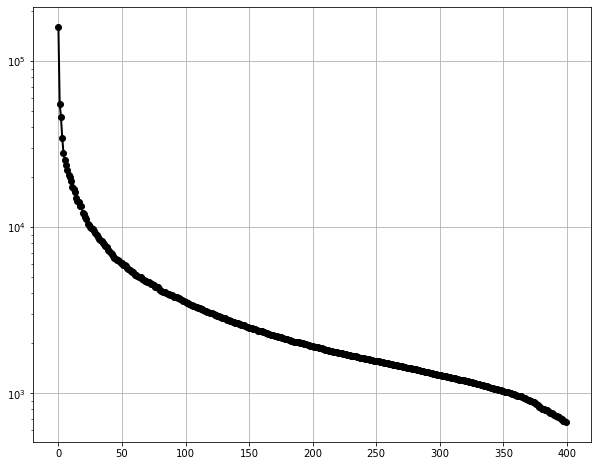

In [11]:
valeur_singuliere(400,0)

In [12]:
# on créé une fonction qui affiche les trois premières images singulières de chaque chiffre
def image_singuliere(n):
    fig, ax = plt.subplots(1,3)
    for i in range(3):
        ax[i].imshow(U[n][:,i].reshape(28,28), cmap='gray')

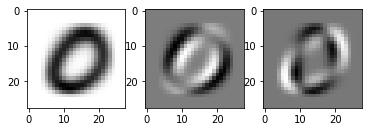

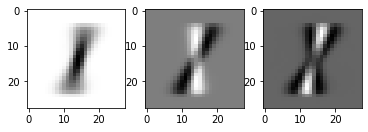

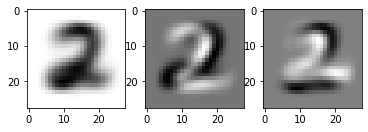

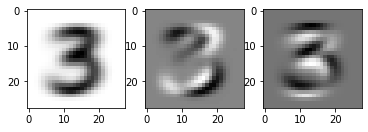

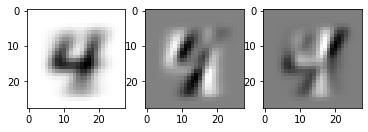

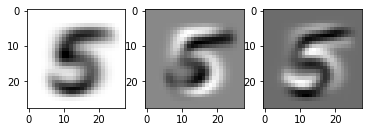

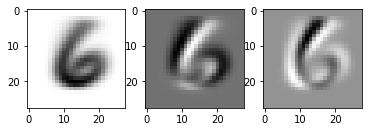

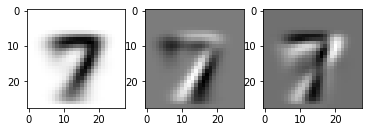

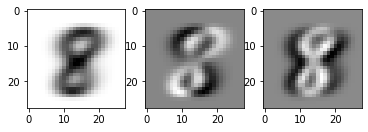

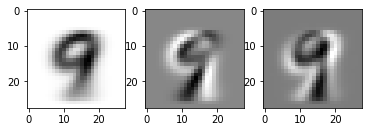

In [13]:
for i in range(10):
    image_singuliere(i)

In [14]:
index0 = index_chiffre(0,y_test)

In [15]:
def moyenne_coor(X, j): # pour le jème right singular vector
    return np.mean(np.array([U[0][:,j][i]/X[i] if X[i]!=0 else 0  for i in range(784)]))

C:\Users\Nazim\anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


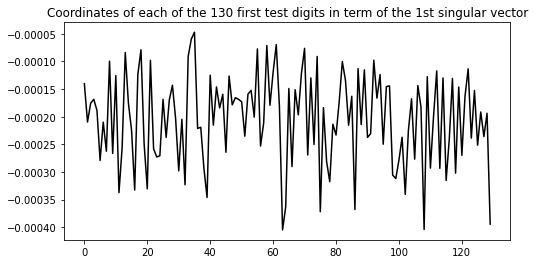

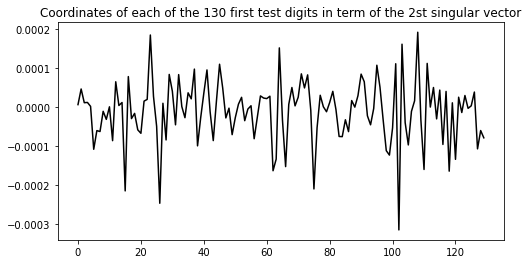

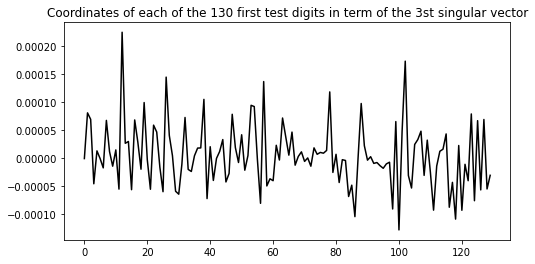

In [16]:
for j in range(3):
    plt.figure(figsize=(8,4))
    coor = []
    for i in index0[:130]:
        coor.append(moyenne_coor(X_test[i],j))
    plt.plot(coor, color='black')
    plt.title('Coordinates of each of the 130 first test digits in term of the '+str(1+j)+'st singular vector')
    plt.show()

In [17]:
def distance(X, n, k):
    I = np.eye(784)
    Uk = U[n][:,:k]
    return np.linalg.norm((I-Uk@np.transpose(Uk))@X,'fro') # essayer en prenant la transposée psk comme ça ça donnera un truc plus maniable

In [18]:
def distance_rec_carre(X, n, k): # pas efficace !
    I = np.eye(784)
    if k==1:
        temp = U[n][:,:1]
        return np.linalg.norm((I-temp@np.transpose(temp))@X,'fro')**2
    else:
        temp = np.c_[U[n][:,:k], np.zeros((784,784-k))] # quand on met :k ça n'inclut pas le k-ième vecteur
        tempz = np.c_[np.zeros((784,k)), U[n][:,k], np.zeros((784,784-k-1))]
        B = (I-temp@np.transpose(temp))@np.c_[X_test[0], np.zeros((784,783))]
        C = temp@np.transpose(tempz)+tempz@np.transpose(temp)+tempz@np.transpose(tempz)  
        return distance_rec_carre(X, n, k-1) + np.trace(B@np.transpose(C)+C@np.transpose(B)+C@np.transpose(C))
                #essayer de changer le paramètre X en appelant la recursion

In [19]:
start = time.time()
test = [distance_rec_carre(X_test[15], n, 10)**(1/2) for n in range(10)]
print(time.time()-start)

7.444485187530518


In [20]:
start = time.time()
dist = [distance(X_test[10], n, 2) for n in range(10)]
print(time.time()-start)

0.07080984115600586


In [21]:
def prediction(X, k):
    dist = [distance(X, n, k) for n in range(10)]
    percentage = np.array(dist/sum(dist))
    percentage = 1-percentage
    return "{:.3f}".format(max(percentage)), dist.index(min(dist))

In [22]:
def afficher_image(X, k):
    plt.imshow(X.reshape(28,28), cmap='gray')
    plt.title("L'image affichée est "+str(prediction(X,k)[1])+" avec un pourcentage de sureté "+str(prediction(X,k)[0])+"% pour le rang "+str(k))
    plt.show()

In [23]:
def pourcentage_prec(n, k):
    pred = [prediction(X_test[i], k)[1] for i in index_chiffre(n, y_test)]
    j=0
    for i in pred:
        if i == n:
            j+=1
    return "{:.3f}".format(j*100/len(index_chiffre(n, y_test)))

In [81]:
def ajouter_prec(k): # k représente le rang qu'on veut ajouter 
    cwd = os.getcwd()
    file = Path(cwd+'\list_prec.npy')
    if file.is_file():
        list_prec = list(np.load('list_prec.npy'))
        # on va d'abord vérifier si on a pas déjà calculer la précision avec ce rang, il suffit de le voir pour un des chiffre
        for t in range(len(list_prec[0])):
            if int(list_prec[0][t][1])==k: # sur cette ligne on parcours le deuxième élément de chaque élément de la liste (qui contient le rang)
                return 'La précision avec ce rang a déjà été calculée.'
        for i in range(10):
            list_prec[i] = np.vstack((list_prec[i],np.array([pourcentage_prec(i,k),k])))
        np.save('list_prec.npy', list_prec)
        return 'La précision pour le rang '+str(k) +' a été enregistrée.'
    else:
        list_prec = [] # c'est la première fois qu'on calculer la précision donc on aura à la calculer seulement pour le rang k
        for i in range(10):
            list_prec.append([pourcentage_prec(i,k),k])
        np.save('list_prec.npy', list_prec)
        return 'La précision pour le rang '+str(k) +' a été enregistrée.'
            

In [150]:

ajouter_prec(50) 
for i in [150, 200, 300, 400, 500, 550]:
    ajouter_prec(i)
    list_prec = np.load('list_prec.npy') # après avoir executer la fonction ajouter_perc on doit mettre à jour ce que vaut list_prec

In [102]:
f = 1000
d = 5000
winsound.Beep(f,d)

In [152]:
list_prec[7]

array([['92.049', '10'],
       ['93.489', '15'],
       ['92.803', '50'],
       ['88.005', '150'],
       ['84.578', '200'],
       ['73.955', '300'],
       ['67.512', '400'],
       ['25.291', '500'],
       ['6.169', '550']], dtype='<U11')

In [110]:
def rearrange(liste): # à appliquer lorsque l'on a une liste de pourcentage déjà existante et qu'on a ajouté à cette dernière un 
    temp = liste.tolist() # rang potentiellement plus petit que celui qu'il y avait à la fin de list_prec
    for i in range(len(temp)):
        temp[i] = [float(temp[i][0]), int(temp[i][1])]
    rank = [temp[i][1] for i in range(len(temp))]
    prec = [temp[i][0] for i in range(len(temp))]
    if rank == sorted(rank): # donc les rangs sont déjà trié il n'y a rien à faire, on va renvoyer la liste donnée en argument
        return (rank, prec, liste)
    else:
        # maintenant on doit les arranger car elle ne sont pas triées
        a = rank[-1] # on récupère le dernier élément qu'on a calculé
        rank = sorted(rank) # on trie la liste des rangs
        new_index = rank.index(a) # on récupère le nouvelle indexe de ce qui était le dernier élément
        b = prec[new_index:-1] # le but de tout ça est de décalé la liste des précisions de sorte à ce qu'elle concorde avec la liste des rangs triées
        new_prec = prec[:new_index] + [prec[-1]] + b
        # le premier morceau est ce qui n'a pas bougé avant l'indexe qu'on a incrusté au milieu de la liste
        # le deuxième morceau et ce qui était à la fin de la liste qu'on a ramené à la fin
        # le dernier morceau et ce qu'on a décalé en ayant pris soin d'enlever la dernière précision
        new_list = []
        for i in range(len(temp)):
            new_list.append([new_prec[i],rank[i]])
        return (rank, new_prec, np.array(new_list))

##### Maintenant on peut afficher les précisions en fonction des rangs pour chaque chiffre

In [113]:
def afficher_graph(prec, n):
    temp = rearrange(prec[n])
    rank, precision = temp[0], temp[1]
    plt.plot(rank, precision, '-o', color='black')
    plt.title('Précisions pour le chiffre '+str(n)+' en fonction du rang')
    plt.grid()
    plt.show()

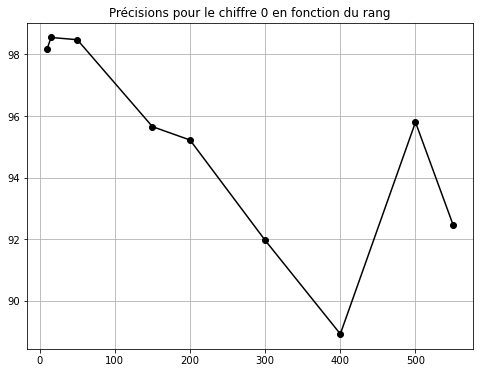

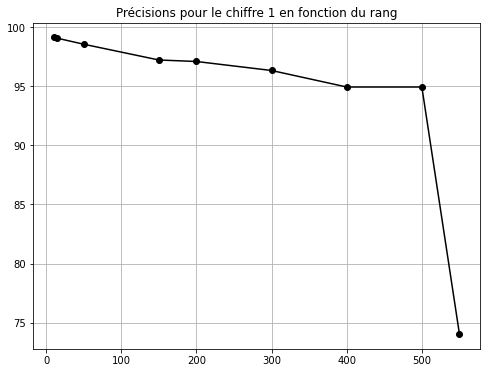

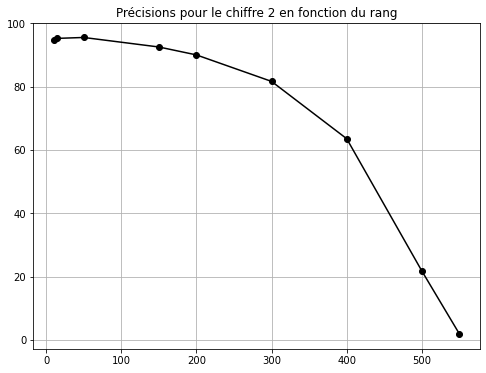

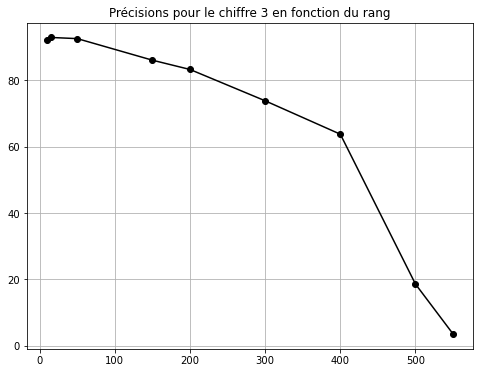

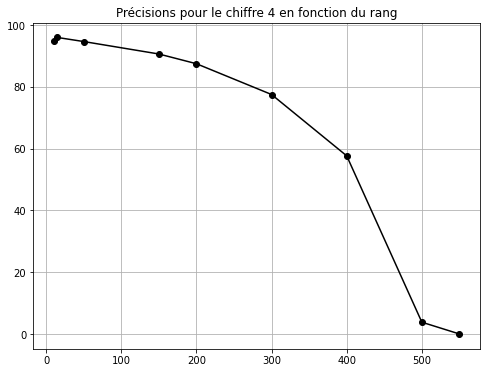

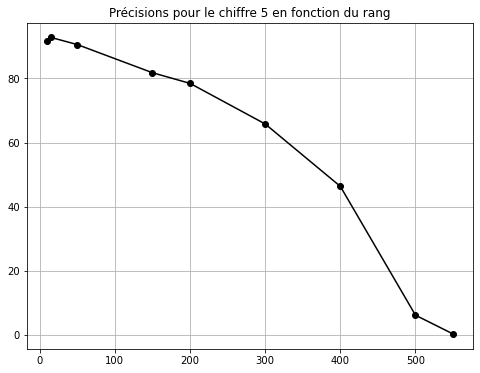

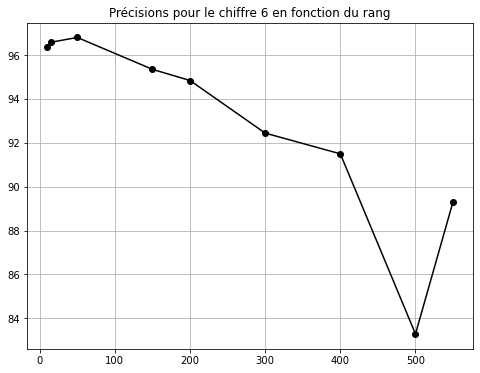

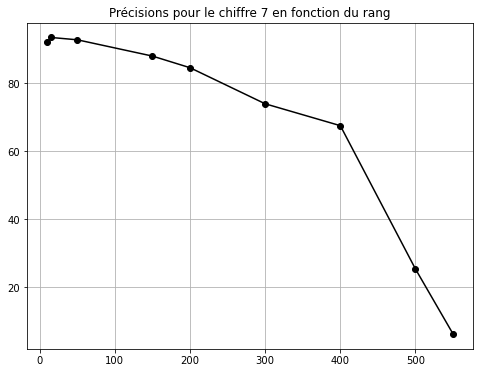

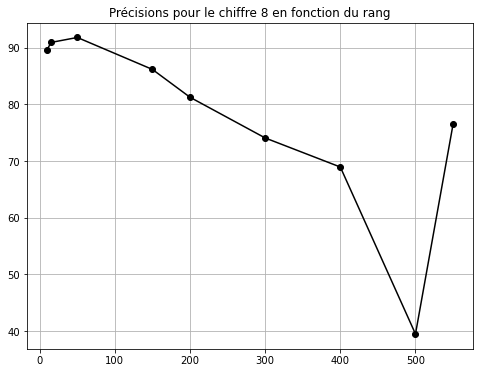

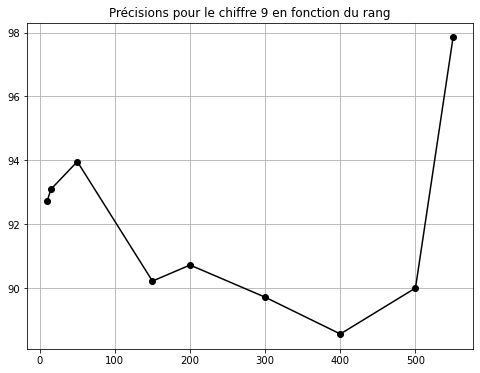

In [114]:
for i in range(10):
    plt.figure(figsize=(8,6))
    afficher_graph(list_prec, i)

In [115]:
list_prec[7]

array([['92.049', '10'],
       ['93.489', '15'],
       ['92.803', '50'],
       ['88.005', '150'],
       ['84.578', '200'],
       ['73.955', '300'],
       ['67.512', '400'],
       ['25.291', '500'],
       ['6.169', '550']], dtype='<U11')

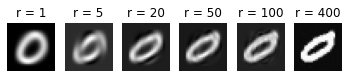

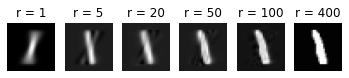

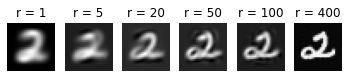

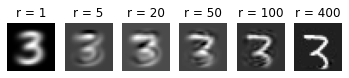

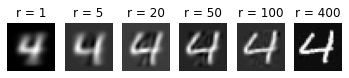

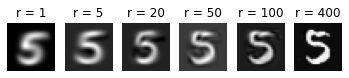

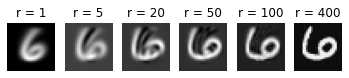

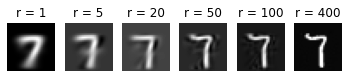

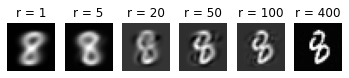

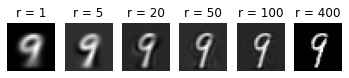

In [131]:
for i in range(10):
    fig, ax = plt.subplots(1,6)
    for (r,j) in zip([1,5,20,50,100,400],range(6)):
        Xapprox = U[i][:,:r]@np.diag(S[i])[:r,:r]@V[i][:r,:] 
        ax[j].imshow(Xapprox[:,1906].reshape(28,28),cmap='gray')
        ax[j].set_title("r = "+str(r))
        ax[j].axis('off')

#### Illustration des résiduelles relatives à chaque espace pour le chiffre n utilisant k éléments des bases

In [123]:
def courbe_chiffre(n, k):
    plt.figure(figsize=(10,8))
    for i in index_chiffre(n, y_test):
        y = [distance(X_test[i], a, k)/np.linalg.norm(X_test[i]) for a in range(10)]
        plt.plot(list(range(10)), y, color='black')
    plt.title('Chiffre '+str(n))
    plt.xlabel('Base')
    plt.ylabel('Résiduelle Relative')
    plt.grid(True)
    plt.show()

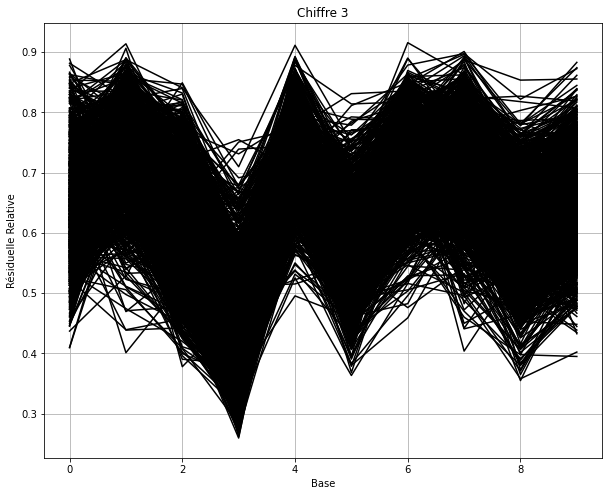

In [134]:
courbe_chiffre(3,15)

#### Tracé de la résiduelle relative d'un nombre X_test[i] à l'espace d'un nombre n en fonction du rang k choisi

In [144]:
def courbe_resid(X, n, k, i): # k représente jusqu'à quel rang on veut aller, i l'indexe de X qu'on choisi
    plt.figure(figsize=(10,8))
    y = [distance(X[i], n, j)/np.linalg.norm(X[i]) for j in range(1,k)]
    plt.plot(list(range(1,k)), y, 'g*-')
    plt.title("Résiduelle Relative d'un " + str(int(y_test[i])) + " à l'espace du " + str(n))
    plt.xlabel("Nombre d'éléments de la base")
    plt.ylabel('Résiduelle Relative')
    plt.grid(True)
    plt.show()

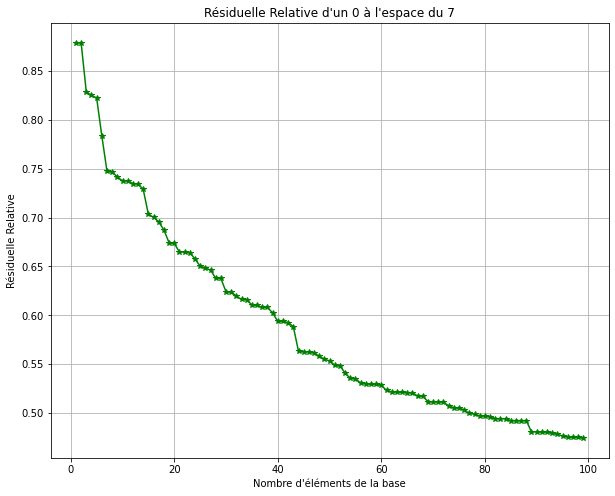

In [148]:
courbe_resid(X_test, 7, 100, 1000)

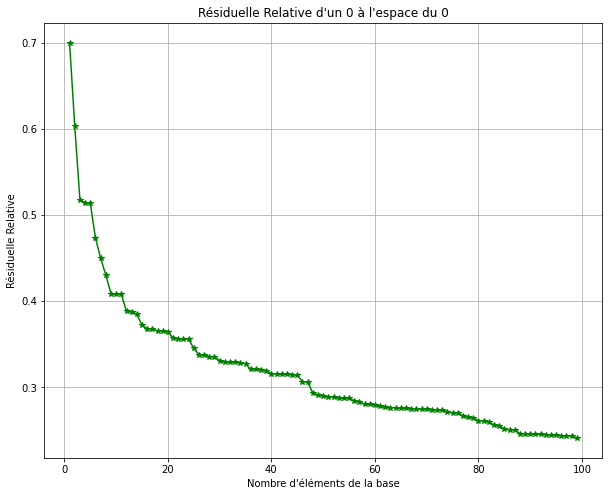

In [149]:
courbe_resid(X_test, 0, 100, 1000)